Question 2

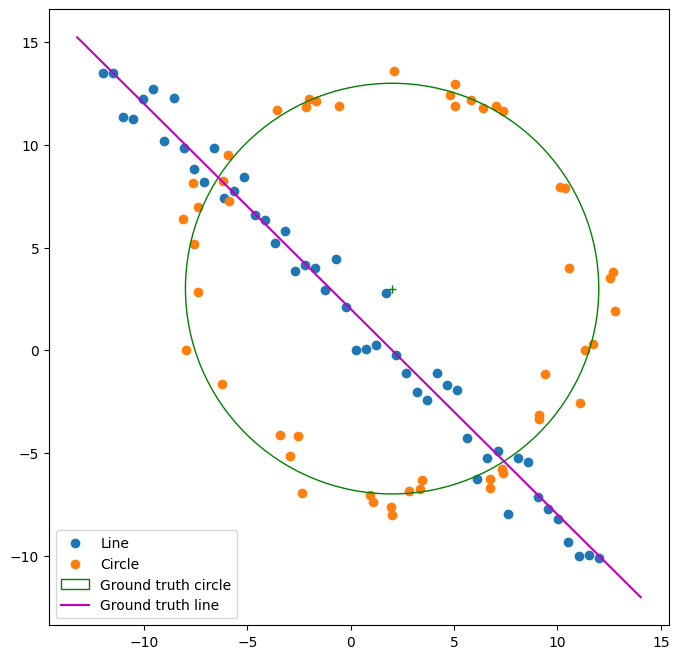

In [6]:
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np.random.uniform(0 , 2*np . pi , half_n )
n = s*np.random.randn( half_n )
x , y = x0_gt + ( r + n)*np.cos( t ) , y0_gt + ( r + n)*np.sin ( t )

X_circ = np.hstack( ( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack(( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )

X = np.vstack( ( X_circ , X_line ) ) # All points


fig , ax = plt.subplots(1 ,1 ,figsize =(8 ,8))
ax.scatter( X_line[ : , 0 ] , X_line[ : , 1 ] , label= 'Line' )
ax.scatter( X_circ[ : , 0 ] , X_circ[ : , 1 ] , label=  'Circle')
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim( )
x_ = np.array( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot( x_ , y_ , color= 'm', label=  'Ground truth line' )
plt.legend( )

2 a) Estimating the line using the RANSAC method

[0.71931319 0.69468593 1.16710823] 7.782613438374182
A better model found ...  [0.71931319 0.69468593 1.16710823] 7.782613438374182
[0.70818537 0.70602655 1.01282406] 6.873879098067278
A better model found ...  [0.70818537 0.70602655 1.01282406] 6.873879098067278
[0.72321372 0.69062431 1.21017775] 10.322823098384184
A better model found ...  [0.72321372 0.69062431 1.21017775] 10.322823098384184
[0.72738164 0.68623319 1.3160101 ] 10.052538837276034
A better model found ...  [0.72738164 0.68623319 1.3160101 ] 10.052538837276034
Best line model [0.72738164 0.68623319 1.3160101 ]


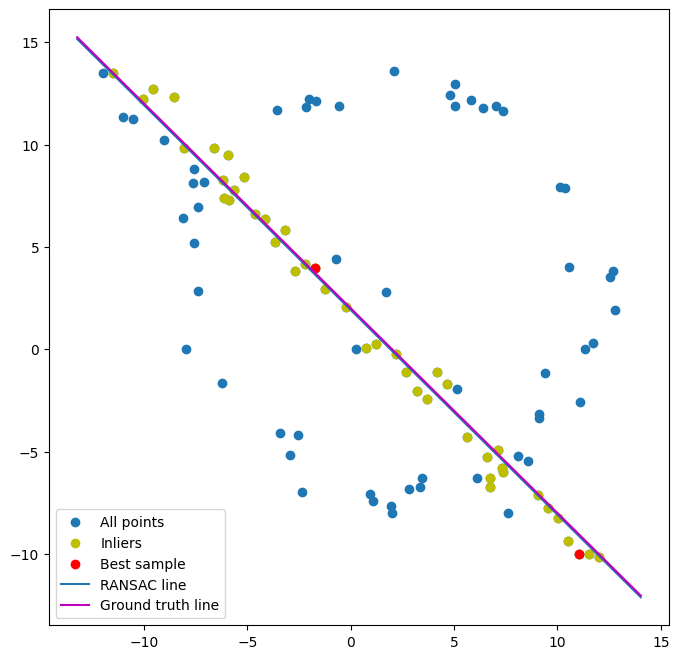

In [7]:
import math
# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
N = X.shape[0]
X_ = X

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Two-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of two (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons)
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons)
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

2 b) Subtracting the consensus and using the remnant to estimate a circle

rex.x:  [ 1.85918928 10.         12.43331133]
Iteration =  0 . No. inliners =  6
0.00521798869025551
rex.x:  [ 2.96359679  4.42785737 10.74345499]
Iteration =  1 . No. inliners =  23
4.249279081335145e-09
rex.x:  [ 2.10193354  2.68894015 10.40521796]
Iteration =  2 . No. inliners =  38
9.978470335167876e-10
[ 1.97007588  2.77875523 10.2211353 ] 6.839736857732606
A better model found ...  [ 1.97007588  2.77875523 10.2211353 ] 6.839736857732606
rex.x:  [ 1.73616425  3.23461964 10.12950347]
Iteration =  3 . No. inliners =  41
3.686018893364384e-09
[ 1.89657806  3.00821224 10.12202164] 9.107473991743525
A better model found ...  [ 1.89657806  3.00821224 10.12202164] 9.107473991743525
rex.x:  [10.          7.21139822 13.14003309]
Iteration =  4 . No. inliners =  6
6.333948270628549
rex.x:  [10.          4.23836638  8.88418525]
Iteration =  5 . No. inliners =  8
1.9217792102878288
rex.x:  [2.62056888 2.73334619 9.93921164]
Iteration =  6 . No. inliners =  39
2.372814193381381e-07
[ 2.2366665

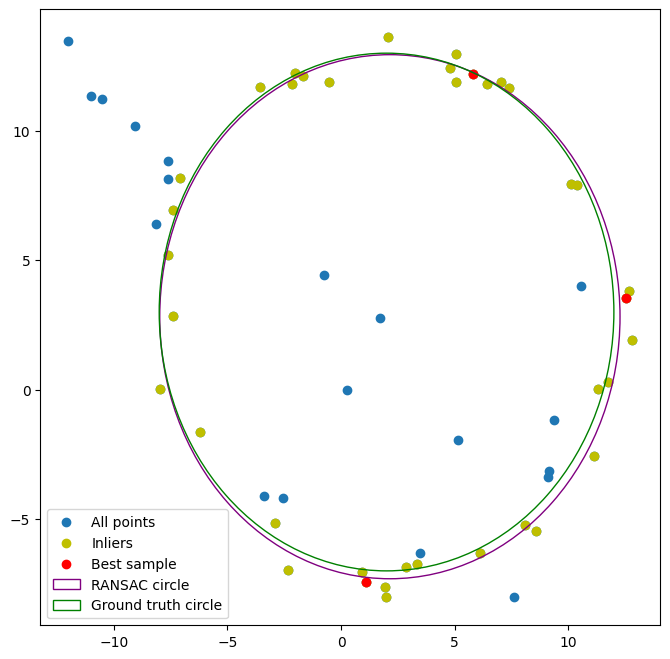

In [8]:
circle = X[~best_inliers_line]
X_ = circle 
N = circle.shape[0]



inliers_circle = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_circle = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_circle = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, r) only using the best sample
best_inliers_circle = []   # Inliers of the model computed form the best sample


# RANSAC to fit a circle
def circle_tls(x, indices):
    a, b, r = x[0], x[1], x[2]
    return np.sum(np.square(np.sqrt(np.square(X_[indices,0] - a) + np.square(X_[indices,1] - b))-r))

# Computing the consensus (inliers)
def consensus_circle(X, x, t):
    a, b, r = x[0], x[1], x[2]
    error = np.absolute(np.sqrt(np.square(X_[:,0] - a) + np.square(X_[:,1] - b))-r)
    return error < t

def g(x):
    return [10 - x[0], 10 - x[1]]  # Constraints to keep x and y less than 10

# Define the constraint dictionary
cons = ({'type': 'ineq', 'fun': g})

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.6*N   # Number of close data points required to assert that a model fits well to data.
s = 3       # Minimum number of data points required to estimate model parameters.


while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 1]) # Initial estimate
    res = minimize(fun = circle_tls, args = indices, constraints = cons, x0 = x0, tol= 1e-6)
    inliers_circle = consensus_circle(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ',  inliers_circle.sum())
    print(circle_tls(res.x, indices))
    if inliers_circle.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = circle_tls, args = inliers_circle, x0 = x0, tol= 1e-6, constraints=cons)
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_circle = res.x
            best_eror = res.fun
            best_sample_circle = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_circle = inliers_circle

    iteration += 1

print('Best circle model', best_model_circle)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(circle[:,0],circle[:,1], label='All points')
ax.scatter(X_[best_inliers_circle,0],X_[best_inliers_circle,1], color='y', label='Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='r', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
plt.legend()



2 c) Showing all the points, RANSAC line, RANSAC circle and the best sample points for the estimation of each, drawn on the same figure.

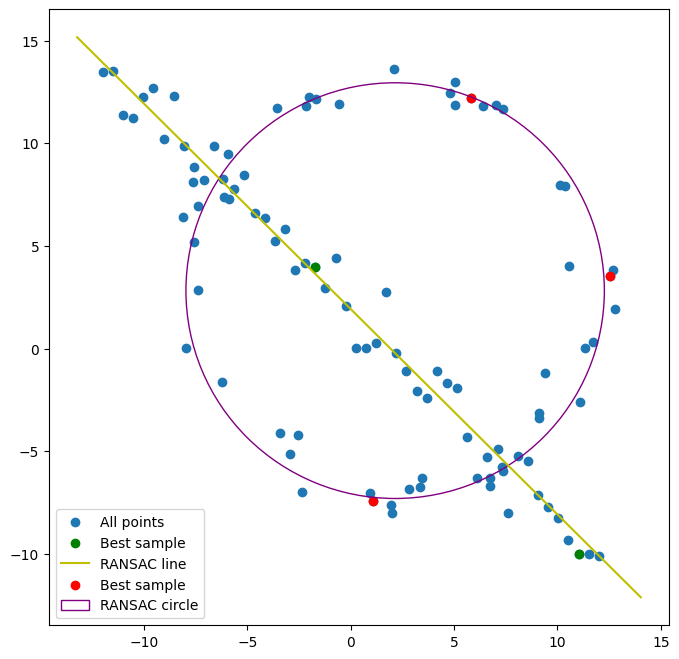

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='g', label='Best sample')
plt.plot(x_, y_, color = 'y' , label='RANSAC line')

ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='r', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
plt.legend()